# Entanglement detection

In [2]:
## import necessary packages
import sys
import numpy as np
import matplotlib as mpl
import math
from cmath import cos, sin, exp, pi, sqrt
# import cmath

# mpl.rcParams['figure.dpi'] = 400
# mpl.rcParams["figure.figsize"] = [10, 6]
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# print(sys.version)
# print(sys.executable)
# print(np.__version__)
# print(mpl.__version__)

from qutip import *

import random
pauli_operators = [qeye(2), sigmax(),sigmay(),sigmaz()]
I, X, Y, Z = qeye(2), sigmax(), sigmay(), sigmaz()

from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


## Entanglement witness

### Dataset generation

In [3]:
# rand_herm
# rand_unitary
# rand_unitary_haar
# rand_dm(N=3)

def generate_rand_product_state(n,m):
    print("----- generate_rand_product_state -----")
    print("number of qubits: ", n, "; number of samples: ", m)
    # print("number of samples: ", m)
    return [
        ket2dm( tensor([ rand_ket(2) for j in range(n) ]) ) for i in range(m)
    ]

def generate_bell_noisy_density(m, kind, noise_limit):
    # p_limit = 1/3
    random_white_noise_p = [random.random() * noise_limit for i in range(m)]

    return [
        ket2dm(bell_state(state=kind)) * (1 - p) + p / 4 * identity([2, 2])
        for p in random_white_noise_p
    ]


# def generate_two_qubit_entangled_pure_state(m):


def generate_bell_like_pure_state(m):
    # permute(order)
    theta_list = [ random.random()*2*pi for i in range(m) ]
    phi_list = [ random.random()*pi for i in range(m) ]

    a_list = [ cos(theta) for theta in theta_list ]
    b_list = [ sin(theta) * exp(phi*1j) for theta in theta_list for phi in phi_list ]
    # x = a* basis(4, 0) + b* basis(4, 3)
    # print(x.norm())
    # print(x)
    # print(x.isket)

    return [ket2dm( a* tensor(basis(2, 0),basis(2, 0)) + b* tensor(basis(2, 1),basis(2, 1)) ) for a in a_list for b in b_list ]


def generate_noisy_ghz_ensemble(n,m,noise_limit):
    return  [ket2dm(ghz_state(N=n)) * (1 - p_noise) +  p_noise / (2**n) * qeye([2 for j in range(n)]) for p_noise in [random.random()*noise_limit for i in range(m)] ]


def generate_noisy_w_ensemble(n, m, noise_limit):
    return [
        ket2dm(w_state(N=n)) * (1 - p_noise) + p_noise /
        (2**n) * qeye([2 for j in range(n)])
        for p_noise in [random.random() * noise_limit for i in range(m)]
    ]
# bell_like_pure_state = generate_bell_like_pure_state(10, False)


def const_label(c, m):
    return [c for i in range(m)]
# generate_rand_product_state(4,3)

### PPT

number of entangled state: 1949
number of separable state: 1051
----- generate_rand_product_state -----
number of qubits:  2 ; number of samples:  3
[-6.36785883e-17]
[-2.0976893e-16]
[-6.30894214e-17]


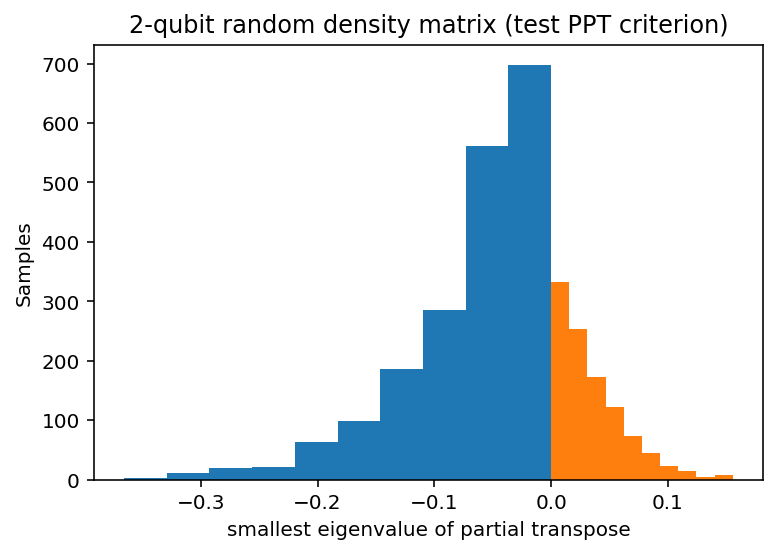

In [4]:
def ppt_criterion(rho):
    # Necessary and sufficient condition (2-qubit): Positive Partial Transpose (PPT)
    rho_out = partial_transpose(rho, [0, 1])
    smallest_eigenval = rho_out.eigenenergies(sort='low', eigvals=1)
    # print(rho_out.eigenenergies(sort='low',eigvals=1))
    # print(smallest_eigenval)
    return smallest_eigenval


def generate_two_qubit_random_state_PPT(m,plot=False):
    rand_dm_2 = [rand_dm(N=4, dims=[[2, 2], [2, 2]]) for i in range(m)]
    # print(ppt_criterion(random.choice(rand_dm_2)))
    entangled = [rho for rho in rand_dm_2 if ppt_criterion(rho) < 0]
    # entangled = [filter(lambda p: ppt_criterion(p) < 0, rand_dm_2)]
    # print(entangled)

    # for product pure states, the smallest eigenvalue is a very very small negative one
    separable = [rho for rho in rand_dm_2 if ppt_criterion(rho) >= 0]
    print('number of entangled state:', len(entangled))
    print('number of separable state:', len(separable))

    # smallest_eigen_list_random = np.array([ppt_criterion(state) for state in rand_dm_2]).flatten()

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4))

        # print(np.array(smallest_eigen_list_entangled).flatten())
        # ax.hist(smallest_eigen_list_random)
        ax.hist(np.array([ppt_criterion(state) for state in entangled]).flatten())
        ax.hist(np.array([ppt_criterion(state) for state in separable]).flatten())
        # ax.text(4, 0.4, r'$$')
        ax.set_ylabel('Samples')
        ax.set_xlabel('smallest eigenvalue of partial transpose')
        ax.set_title('2-qubit random density matrix (test PPT criterion)')

    # plt.savefig('two_qubit_PPT_hist.png', dpi=300)

    return [entangled, separable]

# ppt_criterion(rand_dm(N=4, dims=[[2, 2], [2, 2]]))
generate_two_qubit_random_state_PPT(3000,plot=True)

# generate_two_qubit_random_state_PPT(1000)
# [ppt_criterion(dm) for dm in [ket2dm(ket) for ket in generate_two_qubit_product_pure_state(100)]]
[ppt_criterion(dm) for dm in generate_bell_like_pure_state(10)]

for state in generate_rand_product_state(n=2,m=3):
    eigen_val = ppt_criterion(state)
    print(eigen_val)
# print(rand_dm(N=4,dims=[[2,2],[2,2]]) )

### Visualize dataset samples

----- generate_rand_product_state -----
number of qubits:  2 ; number of samples:  100


(array([ 1.,  1.,  3.,  3.,  7., 17., 16., 29., 18.,  5.]),
 array([-3.82468427e-16, -3.39733614e-16, -2.96998801e-16, -2.54263987e-16,
        -2.11529174e-16, -1.68794361e-16, -1.26059548e-16, -8.33247344e-17,
        -4.05899211e-17,  2.14489216e-18,  4.48797054e-17]),
 <BarContainer object of 10 artists>)

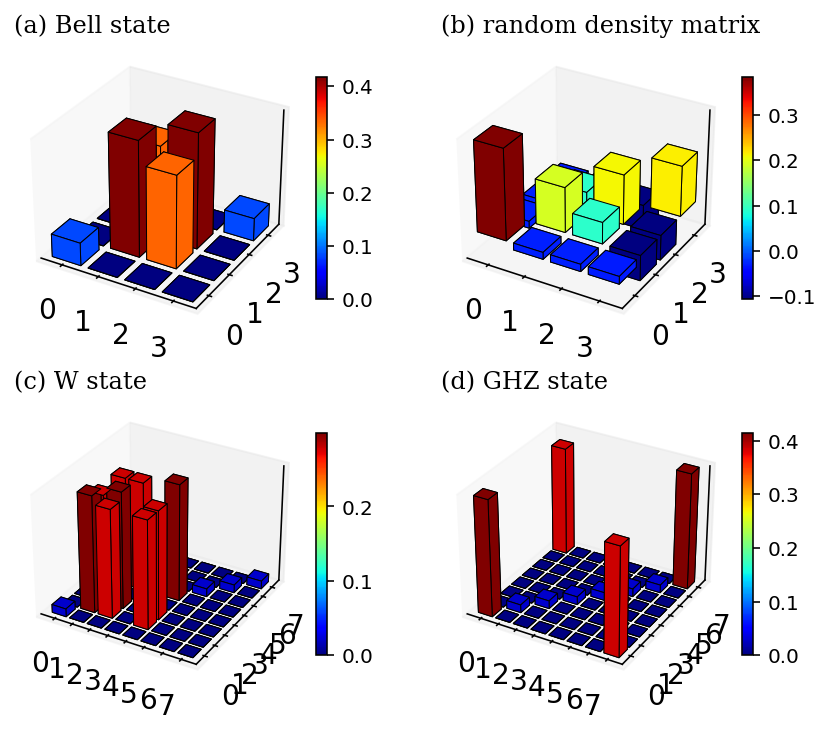

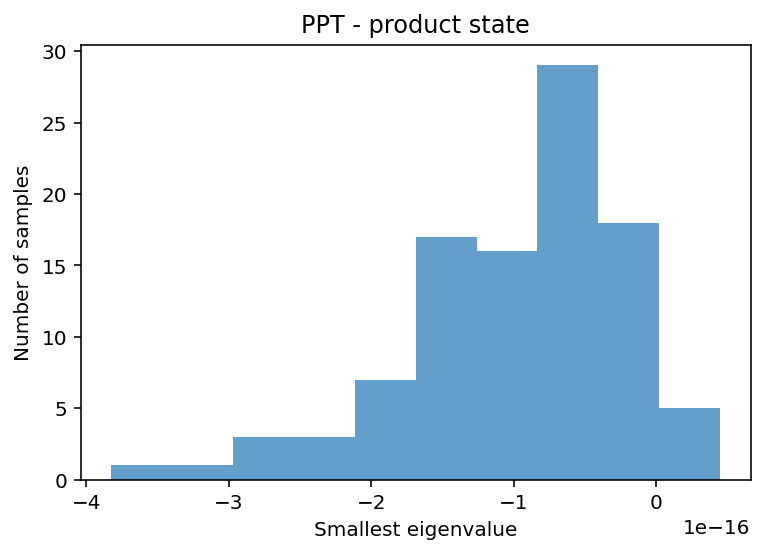

In [12]:
size_train = 10

# visualization
# fig = plt.figure(figsize=plt.figaspect(0.5))
fig = plt.figure(figsize=(7, 6))
# fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('(a) Bell state', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(generate_bell_noisy_density(m=size_train,kind='10',noise_limit=1/3)), fig=fig, ax=ax)
# xlabels=['00', '01', '10', '11'],
# ylabels=['00', '01', '10', '11'],
# title="a random two qubit entangled state",

# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title('(b) random density matrix', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice([rand_dm(N=4, dims=[[2, 2], [2, 2]]) for i in range(size_train)]), fig=fig, ax=ax)

# W
w_3_density = generate_noisy_w_ensemble(3,size_train,1/3)
# set up the axes for the first plot
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_title('(c) W state', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(w_3_density), fig=fig, ax=ax)

# GHZ
ghz_3_density = generate_noisy_ghz_ensemble(3,size_train,1/3)
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title('(d) GHZ state', fontfamily='serif', loc='left', fontsize='large')
matrix_histogram(random.choice(ghz_3_density), fig=fig, ax=ax)

plt.savefig('dataset_sample.png', dpi=300)

fig, ax = plt.subplots(figsize=(6, 4))

smallest_eigen_list_entangled = [ ppt_criterion(state) for state in generate_rand_product_state(2,100) ]
# print(smallest_eigen_list_entangled)
# print(np.array(smallest_eigen_list_entangled).flatten())
ax.set_ylabel('Number of samples')
ax.set_xlabel('Smallest eigenvalue')
ax.set_title('PPT - product state')
ax.hist(np.array(smallest_eigen_list_entangled), alpha=0.7)



### machine learning ansatz

### Bell, CHSH inequalities as entanglement witness

the Bell inequality
$$ \langle a_0b_0, a_0b_0', a_0'b_0, a_0'b_0' \rangle$$
with $a_0=\sigma_x$, $a_0'=\sigma_x$, $b_0=(\sigma_x-\sigma_z)/\sqrt{2}$, and $b_0'=(\sigma_x+\sigma_z)/\sqrt{2}$

the CHSH inequality
$$ \langle \rangle$$


In [ ]:
a_0 = sigmaz()
a_1 = sigmax()
b_0 = (sigmax() - sigmaz() )/sqrt(2)
b_1 = (sigmax() + sigmaz())/sqrt(2)
bell_ansatz = [ tensor(a_0,a_1), tensor(a_1,b_0), tensor(a_1,b_1), -tensor(a_0,b_1) ]
bell_inequality = tensor(a_0,a_1) + tensor(a_1,b_0) + tensor(a_1,b_1) - tensor(a_0,b_1) 


In [75]:
# size_train = 100
# size_test = 10

# rigorous witness

# Bell inequality

# machine learning ansatz

# w_ansatz = tensor([sigmax(), sigmax(), sigmaz()])
# print(w_ansatz)


In [20]:
def construct_training_dataset(states,labels,operators):
    print("====== construct_training_dataset =======")
    # from functools import reduce
    # for state in reduce(lambda x, y: x + y, states)
    # y = np.array(labels).flatten()
    all_states =  sum(states, [])
    y = np.array(sum(labels,[]))
    n_sample = len(all_states)

    # evaluate features - expectation values
    features = np.array([ expect(operators, state) for state in all_states ])

    np.random.seed(1)
    order = np.random.permutation(n_sample)
    # print(order)
    features = features[order]
    y = y[order]
    # y = y[order].astype(float)
    # print(y)
    # print(features)

    print('number of samples:', n_sample, '; number of labels:', len(y), '; dimension:', shape(features))
    return (features, y)


# number_samples = 1000
size_train = 3

bell_kinds = ['00', '01', '10', '11']
pauli_str = ['I', 'X', 'Y', 'Z']
two_pauli = [tensor([a,b]) for a in pauli_operators for b in pauli_operators ]
two_pauli_label = [a+b for a in pauli_str for b in pauli_str ]
print(two_pauli_label)
# print(two_pauli)

# print(expect(two_pauli,bell_state('11')))
X_0 = generate_bell_noisy_density(size_train,kind='11',noise_limit=1/3)
y_0 = [0 for i in range(size_train)]
X_1 = generate_rand_product_state(n=2,m=size_train)
y_1 = [1 for i in range(size_train)]
X, y = construct_training_dataset([X_0, X_1, X_1], [y_0, y_1, y_1],two_pauli)

['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
----- generate_rand_product_state -----
number of qubits:  2 ; number of samples:  3
====== construct_training_dataset =======
number of samples: 9 ; number of labels: 9 ; dimension: (9, 16)


### 2-qubit case

----- generate_rand_product_state -----
number of qubits:  2 ; number of samples:  40
====== construct_training_dataset =======
number of samples: 80 ; number of labels: 80 ; dimension: (80, 16)
============== summary ===============
size of training set: 80 ; size of testing set: 10
kernel method: linear kernel
---- recursive feature elimination ----
feature filter: [False False False False False False  True False False  True False False
 False False  True False]
feature ranking: [14  3  5  8  6 12  1 10  7  1 11  2  4  9  1 13]
----------------------------------------
score (train): 0.7361111111111112
score (test): 0.75
number of entangled state: 8
number of separable state: 2
accuracy of prediction (other entangled): 0.0
============== end ===============


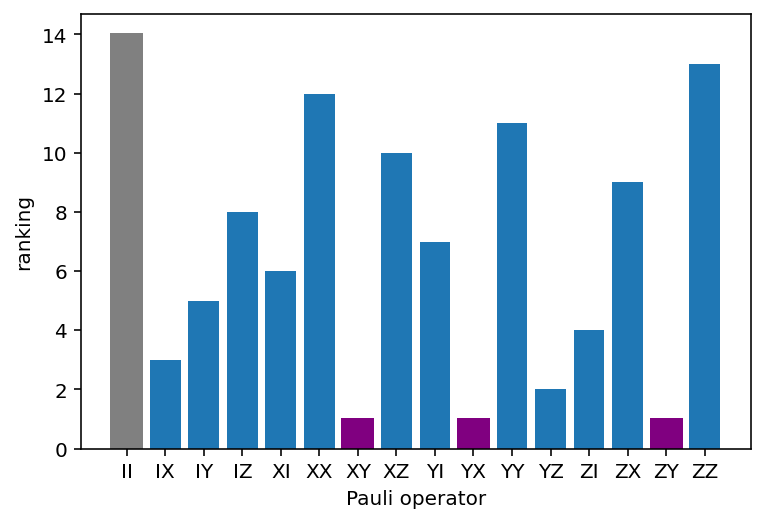

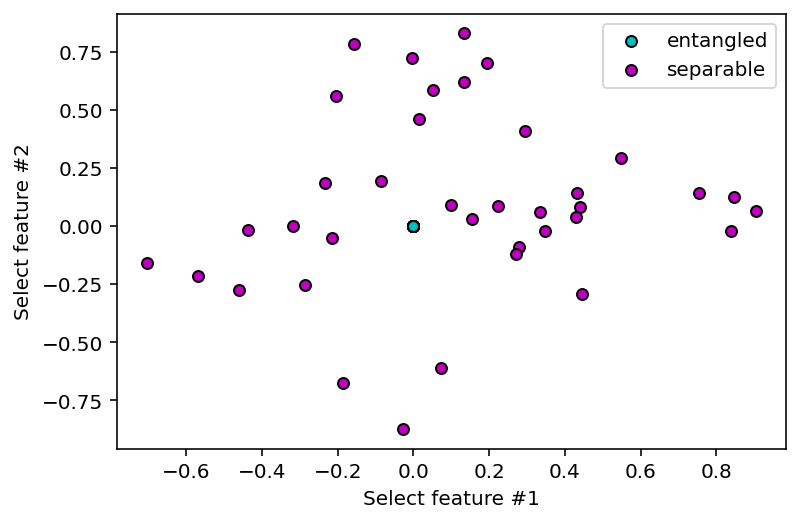

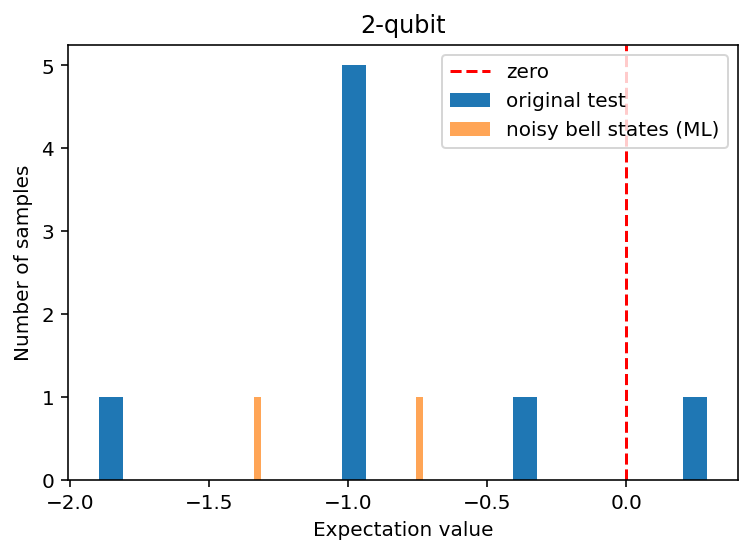

In [39]:
# figure = plt.figure(figsize=(10, 6))
# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
# fig, axes = plt.subplots(1, 2, figsize=(12,3))
# ax = plt.subplot(1,2,1)


def my_svm(X, y, size_test, kernel, legend, rfe=False, to_features=3):
    ################# SVM training ####################
    print("============== summary ===============")
    print("size of training set:", len(X), "; size of testing set:", size_test)
    # print("size of testing set:", size_test)
    n_sample = len(X)
    X_train = X[:int(0.9 * n_sample)]
    y_train = y[:int(0.9 * n_sample)]
    X_test = X[int(0.9 * n_sample):]
    y_test = y[int(0.9 * n_sample):]

    # we create an instance of SVM and fit out data.
    if kernel == 'linear':
        # linear kernel
        print("kernel method: linear kernel")
        if rfe:
            print("---- recursive feature elimination ----")
            estimator = SVC(kernel="linear", C=1)
            clf = RFE(estimator=estimator, n_features_to_select=to_features, step=1)
            clf.fit(X_train, y_train)
            filter = clf.support_
            print('feature filter:', filter)
            ranking = clf.ranking_.reshape(X_train[0].shape)
            print('feature ranking:', ranking)
            print('----------------------------------------')
            # print(y_train)
            fig_rank, ax_rank = plt.subplots(figsize=(6, 4))
            barlist = ax_rank.bar(two_pauli_label,ranking)
            for index, item in enumerate(ranking):
                if item == max(ranking):
                    barlist[index].set_color('gray')
                if item == min(ranking):
                    barlist[index].set_color('purple')

            ax_rank.set_ylabel('ranking')
            ax_rank.set_xlabel('Pauli operator')
            # ax_rank.legend(['','',''])
            plt.savefig('feature_rank.png', dpi=200)

            fig_feature, ax_feature = plt.subplots(figsize=(6, 4))
            # ax_feature.scatter(X_train[:, filter][:, 0], X_train[:, filter][:, 1], c=y_train, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20)
            # https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option
            cdict = {0: 'c', 1: 'm', 2: 'y'}
            # https://matplotlib.org/stable/gallery/color/named_colors.html
            for g in np.unique(y_train):
                ix = np.where(y_train == g)
                ax_feature.scatter(X_train[:, filter][ix, 0], X_train[:, filter][ix, 1], c = cdict[g], edgecolor="k", s = 30)
            ax_feature.set_ylabel('Select feature #2')
            ax_feature.set_xlabel('Select feature #1')
            ax_feature.legend(['entangled', 'separable'], loc='upper right')
            plt.savefig('feature_space.png', dpi=300)
        else:
            clf = svm.SVC(kernel='linear')
            # clf = svm.SVC(kernel=my_kernel)
            # # clf.get_params()
            clf.fit(X_train, y_train)
            # print('score:', clf.score)
            print('coef0:', clf.coef0)
            print('coef_:', clf.coef_)
            print('intercept_:', clf.intercept_)
    else:
        # kernel
        print("kernel method: rbf")
        clf = svm.SVC()
        clf.fit(X_train, y_train)

    print('score (train):', clf.score(X_train, y_train))
    print('score (test):', clf.score(X_test, y_test))
    # print(clf.score)

    fig, ax = plt.subplots(figsize=(6, 4))

    ################# test/prediction ####################
    prediction_test = clf.predict(X_test)
    decision_test = clf.decision_function(X_test)
    # # print(prediction)
    # print("accuracy of prediction 0 (bell entangled):", sum((1-prediction_0))/len(prediction_0))
    ax.hist(decision_test, bins=25)
    ax.axvline(0.0, ls="--", color="r")

    # test_2 = generate_bell_like_pure_state(10)
    test_2 = generate_two_qubit_random_state_PPT(size_test)[1]
    # test_2 = generate_rand_product_state(2,size_test)
    # test_2 = generate_bell_noisy_density(size_test,'10',1/3)
    feature_2 = [ expect(two_pauli, state) for state in test_2 ]
    prediction_2 = clf.predict(feature_2)
    # print(prediction_2)
    decision_2 = clf.decision_function(feature_2)
    ax.hist(decision_2, alpha=0.7, bins=25)
    print("accuracy of prediction (other entangled):", sum(prediction_2)/len(prediction_2))

    # ax.hist([expect(state, bell_inequality) for state in test_0 ])
    # ax.hist([expect(state, bell_inequality) for state in [ ket2dm(ket) for ket in test_1 ] ])
    # ax.hist([expect(state, bell_inequality) for state in test_2 ])

    print("============== end ===============")
    ax.set_ylabel('Number of samples')
    ax.set_xlabel('Expectation value')
    ax.set_title('2-qubit')
    ax.legend(legend, loc='upper right')
    plt.savefig('two_qubit_hist.png', dpi=300)

    # return clf


# traing with the entries of the density matrix

size_train = 10
size_test = 10
bell_noise = 1 / 3

bell00_noisy = generate_bell_noisy_density(size_train, '00', bell_noise)
# print(bell00_noisy_density[0])
bell01_noisy = generate_bell_noisy_density(size_train, '01', bell_noise)
bell10_noisy = generate_bell_noisy_density(size_train, '10', bell_noise)
bell11_noisy = generate_bell_noisy_density(size_train, '11', bell_noise)

bell_like_train = bell00_noisy + bell01_noisy + bell10_noisy + bell11_noisy

two_qubit_product_states_train = generate_rand_product_state(
    n=2, m=len(bell_like_train))

labels = [
    const_label(0, size_train),
    const_label(0, size_train),
    const_label(0, size_train),
    const_label(0, size_train),
    const_label(1, len(two_qubit_product_states_train))
]
# print(labels)

X, y = construct_training_dataset(
    states=[bell_like_train, two_qubit_product_states_train],
    labels=labels,
    operators=two_pauli)


# (X, Y) = assemble_training_dataset(size_train)
legends = ['zero', 'original test','noisy bell states (ML)', 'separable states (ML)', 'random density matrices (ML)', 'bell inequality']
my_svm(X=X, y=y, size_test=size_test, kernel='linear', legend=legends, rfe=True)
# my_svm(X, Y, 1000, 100, 'linear')

### distinguish bi-separable and entangled (2-qubit)

number of entangled state: 667
number of separable state: 333
====== construct_training_dataset =======
number of samples: 600 ; number of labels: 600 ; dimension: (600, 16)
============== summary ===============
size of training set: 600 ; size of testing set: 100
kernel method: linear kernel
---- recursive feature elimination ----
feature filter: [False False False False False False False False False False False  True
 False False  True  True]
feature ranking: [14 12 11  9  6  2  5  8 10  3  4  1  7 13  1  1]
----------------------------------------
score (train): 0.5666666666666667
score (test): 0.5833333333333334
number of entangled state: 62
number of separable state: 38
accuracy of prediction (other entangled): 0.6842105263157895
============== end ===============


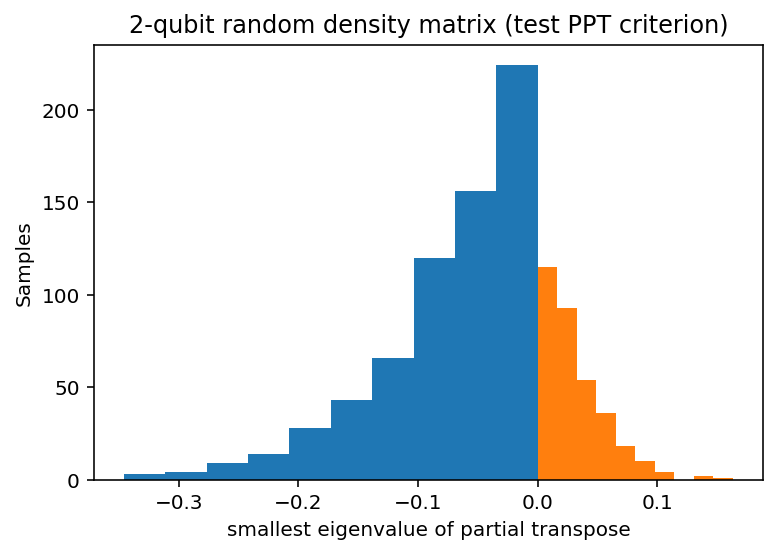

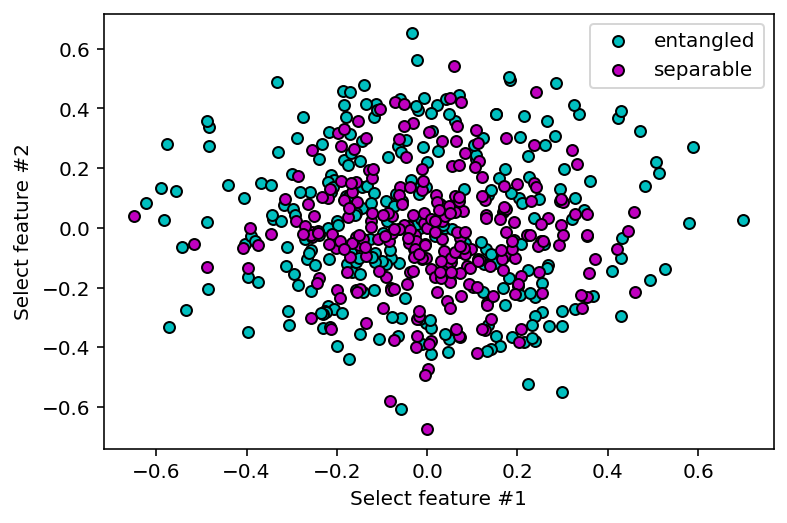

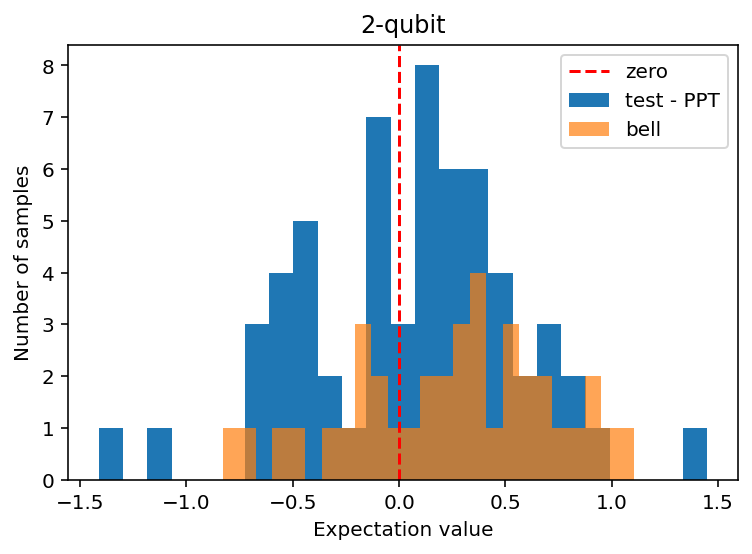

In [8]:
size_train = 1000
two_qubit_random_state_PPT = generate_two_qubit_random_state_PPT(size_train,plot=True)
entangled_sample = two_qubit_random_state_PPT[0][:int(0.3*size_train)]
separable_sample = two_qubit_random_state_PPT[1][:int(0.3 * size_train)]

labels = [ const_label(0,len(entangled_sample)) , const_label(1,len(separable_sample)) ]

X,y = construct_training_dataset(states=[entangled_sample,separable_sample],labels=labels,operators=two_pauli)
my_svm(X=X, y=y, size_test=100, kernel='linear',legend=['zero','test - PPT','bell'],rfe=True)
# my_svm(X=X, y=y, size_test=100, kernel='rbf',legend=['zero','test - PPT','bell'])


##### Two-qutrit
...
##### Two-qudit


In [141]:
# qutrit_basis()
x = basis(3, 2)
M = ket2dm(x)
print(M)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


### Three-qubit case

fully separable, biseparable

GME, fully entanglement

----- generate_rand_product_state -----
number of qubits:  3 ; number of samples:  100
----- generate_rand_product_state -----
number of qubits:  3 ; number of samples:  200
====== construct_training_dataset =======
number of samples:  400 ; number of labels:  400 ; dimension:  (400, 64)
1.0
----- generate_rand_product_state -----
number of qubits:  3 ; number of samples:  100


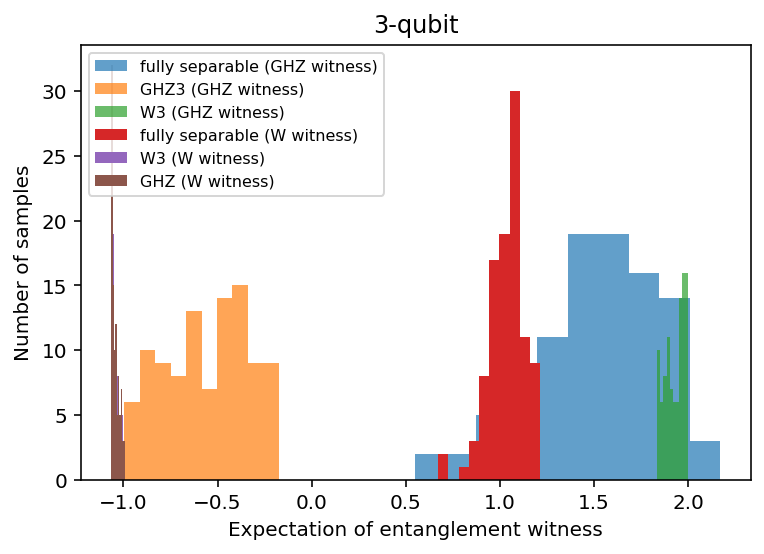

In [139]:
size_train = 100
size_test = 100

# three-qubit tomographic ansatz
three_pauli = [tensor([a,b,c]) for a in pauli_operators for b in pauli_operators for c in pauli_operators]

## generate training data
# GHZ and W state samples with white noise
ghz_3_density = generate_noisy_ghz_ensemble(n=3,m=size_train,noise_limit=1/3)
w_3_density = generate_noisy_w_ensemble(n=3,m=size_train,noise_limit=1/3)


# rigorous entanglement witness - local measurements
witness_ghz_3 =  3/2 * qeye([2, 2, 2]) - tensor([sigmax(), sigmax(), sigmax()]) - 1/2 * (tensor([sigmaz(), sigmaz(), qeye([2])]) + tensor([qeye([2]), sigmaz(), sigmaz()]) + tensor([sigmaz(), qeye([2]), sigmaz()]))
# rigorous entanglement witness - projection
witness_w_3_project = 2/3 * qeye([2, 2, 2]) - ket2dm(w_state(N=3))
# witness_ghz_3_project = 1/2 * qeye([2, 2, 2]) - ket2dm(ghz_state(N=3))


fig, ax = plt.subplots(figsize=(6, 4))
# test GHZ3 projection witness
for test_set in [generate_rand_product_state(3,size_train), ghz_3_density, w_3_density]:
    prediction_witness_ghz_3 = [
        expect(witness_ghz_3, state) for state in test_set
    ]
    ax.hist(prediction_witness_ghz_3, alpha=0.7)

# test W3 projection witness
# for test_set in [ generate_rand_product_state(n=3,m=size_train), ghz_3_density, w_3_density]:
#     prediction_witness_w_3_project = [
#         expect(witness_w_3_project, state) for state in test_set
#     ]
#     ax.hist(prediction_witness_w_3_project, alpha=0.7)

##################### training ########################
input_states = [generate_rand_product_state(3, 2 * size_train), ghz_3_density, w_3_density]
labels = [ [1 for i in range(2 * size_train)], [0 for i in range(size_train) ], [0 for i in range(size_train)] ]
# print(labels)
X, Y = construct_training_dataset(states=input_states,labels=labels,operators=three_pauli)
# print(Y)
clf = svm.SVC()
clf.fit(X, Y)
print(clf.score(X, Y))

##################### testing ########################
ghz3_test = generate_noisy_ghz_ensemble(n=3,m=size_test,noise_limit=1/3)
w3_test = generate_noisy_w_ensemble(n=3,m=size_test,noise_limit=1/3)
test_dataset = [generate_rand_product_state(3, size_test), ghz3_test, w3_test]
# test_1 = generate_two_qubit_random_pure_state_PPT(size_test)[1]
for test_data in test_dataset:
    feature_test = [expect(three_pauli, state) for state in test_data]
    prediction_test = clf.predict(feature_test)
    # print(prediction_three_1)
    decision_test = clf.decision_function(feature_test)
    ax.hist(decision_test)

##################### plot ########################
# ax.text(4, 0.4, r'$$')
ax.set_ylabel('Number of samples')
# ax.set_ylabel(r'$ \tr (W \rho ) $')
ax.set_xlabel('Expectation of entanglement witness')
ax.set_title('3-qubit')
ax.legend(('fully separable (GHZ witness)', 'GHZ3 (GHZ witness)', 'W3 (GHZ witness)', 'fully separable (W witness)','W3 (W witness)', 'GHZ (W witness)', 'fully separable (ML)', 'GHZ (ML)', 'W (ML)'), loc='upper left',prop ={'size': 8})

# fig.show()
plt.savefig('three_qubit_hist.png', dpi=300)


### Feature elimination

In [13]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py


### Stabilizer - few local measurement

##### mixed state

Werner state

In [377]:
# plot_expectation_values(results, ylabels=[], title=None, show_legend=False, fig=None, axes=None, figsize=(8, 4))

# plot_wigner_sphere(fig, ax, wigner, reflections)

#### Four-qubit case

graph state - ring
....

2D cluster state

In [140]:
# some visualization

# Schmidt decomposition
# plot_schmidt(w_state(3), splitting=2, labels_iteration=(3, 2), theme='light', fig=None, ax=None, figsize=(6, 6))

# bell state
# bell_state(state='00')
# singlet_state()

# b = Bloch()
# # pnt = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]
# # b.add_points(pnt)
# b.add_states([rand_ket(2) for i in range(200)])
# b.render()
# b.show()

## Versions of software package/module 

In [142]:
# about()
# from qutip.ipynbtools import version_table
# version_table()
# qutip.cite()

# conda list

# print(sklearn.__version__)

In [29]:
# https://vprusso.github.io/toqito/
from toqito.nonlocal_games.xor_game import XORGame

# The probability matrix.
prob_mat = np.array([[1/4, 1/4], [1/4, 1/4]])

# The predicate matrix.
pred_mat = np.array([[0, 0], [0, 1]])

# Define CHSH game from matrices.
chsh = XORGame(prob_mat, pred_mat)
chsh.classical_value()
chsh.quantum_value()

0.8535533908447781